In [1]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np
import sklearn
import math

#plotting
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Markdown, display
import ipywidgets as widgets
import seaborn as sns
sns.set()

#Pipelines
from source import *
import source.fairness as fm
import source.pipes as op

#Sampling
from sklearn.model_selection import train_test_split

#Storing trains
import pickle

## Exploring Data Set

In [2]:
ds = pd.read_csv('dataset/final_dataset.csv', sep = ',', index_col = 0)

In [3]:
for i, x in enumerate(ds.columns):
    print("{0}-{1}: {2}, Nan: {3:2f}".format(i, x, ds[x].dtype, 100*ds[x].isna().sum()/4983))

0-Genero: int64, Nan: 0.000000
1-Grupo_Dependencia_Colegio_F: object, Nan: 0.000000
2-Rama_Educacional_Colegio_Grupo: object, Nan: 2.087096
3-Ing_Bruto_Familiar_F: float64, Nan: 2.267710
4-Preferencia_Carrera_F: float64, Nan: 1.264299
5-Colegio_Promedio_PSU: float64, Nan: 15.291993
6-Colegio_Total_Alumnos: float64, Nan: 15.291993
7-Prom_Alumn_Dif: float64, Nan: 15.291993
8-PSU_Matematica_F: float64, Nan: 3.210917
9-PSU_Lenguaje_F: float64, Nan: 3.210917
10-PSU_Ciencias: float64, Nan: 49.006623
11-PSU_Historia: float64, Nan: 42.544652
12-PSU_Hist_Ciencias: float64, Nan: 21.573349
13-PSU_Ranking_F: float64, Nan: 2.749348
14-Notas_Enseñanza_Media: float64, Nan: 19.947823
15-Tipo_Ingreso: object, Nan: 16.616496
16-Region_Residencia_Eq: object, Nan: 0.000000
17-Participa_EDT: int64, Nan: 0.000000
18-Participa_EDV: int64, Nan: 0.000000
19-Participa_PAA_1Sem: int64, Nan: 0.000000
20-Participa_PAA_2Sem: int64, Nan: 0.000000
21-Prom_1er_Sem: float64, Nan: 0.903070
22-Primer_Semestre_MEM: float6

In total we have 4,706 observations and 45 variables. Some of them are useful and other not. We should filter and select those we are using in our model. According to expert judgment, we will select those useful features on X, the protected attributes in A, and the potential label in Y, which represent the dropout decision of student.

In [5]:
#Selecting useful variables
Y = ds.iloc[:,range(40,45)]
A = ds.iloc[:,[0,1]]
X = ds.iloc[:,range(2,40)]

In [6]:
print("In total we have {0} features for X, {1} for A, and {2} for Y".format(len(X.columns), len(A.columns), len(Y.columns)))

In total we have 38 features for X, 2 for A, and 5 for Y


In [7]:
A_dummy = pd.get_dummies(A)
A_dummy = A_dummy.iloc[:,0:2]
A_dummy.columns = ['gender', 'public_school']
A_dummy['gender'] = 1-A_dummy['gender']

## Let analyze the Elimination Cuase

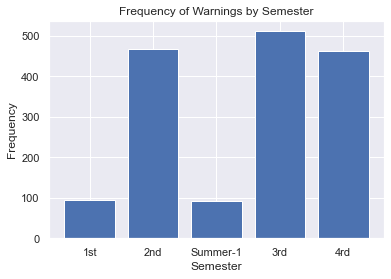

In [7]:
plt.bar('1st',Y['CausalSem-11'].sum(), color = 'b')
plt.bar('2nd', Y['CausalSem-12'].sum(), color = 'b')
plt.bar('Summer-1', Y['CausalSem-2v'].sum(), color = 'b')
plt.bar('3rd',Y['CausalSem-21'].sum(), color = 'b')
plt.bar('4rd',Y['CausalSem-22'].sum(), color = 'b')

plt.xlabel('Semester')
plt.ylabel('Frequency')
plt.title('Frequency of Warnings by Semester')

plt.savefig('causesfreq.png')

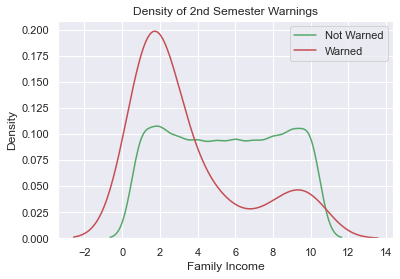

In [8]:
#Save the numerical and nominal variables
numerical = [i for i, e in enumerate(X.dtypes) if e == 'float64']

def f(var, y):
    fig, ax1 = plt.subplots()

    sns.axes_style("darkgrid")
    g = sns.kdeplot(X[Y[y]==0][var], color='g', label = 'Not Warned')
    g = sns.kdeplot(X[Y[y]==1][var], color='r', label = 'Warned')
    #g.set(xlabel = 'Performance 1st Sem')
    g.set(xlabel = 'Family Income')
    g.set(title = 'Density of 2nd Semester Warnings')

    ax1.legend()
    plt.show()

l = []
for var in X.iloc[:,numerical].columns:
    l.append((var,var))

y_var = []
for var in Y.columns:
    y_var.append((var,var))

interact(f, var=l, y=y_var);

## Let analyze the distribution for Gender

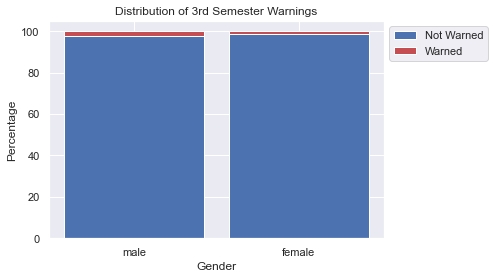

In [9]:
def f(var):
    N = ['male','female']
    totals = [i+j for i,j in zip(A.loc[Y[var]==0,"Genero"].value_counts(), A.loc[Y[var]==1,"Genero"].value_counts())]
    blueBars = [i / j * 100 for i,j in zip(A.loc[Y[var]==0,"Genero"].value_counts(), totals)]
    redBars = [i / j * 100 for i,j in zip(A.loc[Y[var]==1,"Genero"].value_counts(), totals)]
    
    # plot
    barWidth = 0.85
    # Create green Bars
    plt.bar(N, blueBars, color='b', edgecolor='white', width=barWidth, label = 'Not Warned')
    # Create orange Bars
    plt.bar(N, redBars, bottom=blueBars, color='r', edgecolor='white', width=barWidth, label = 'Warned')
    
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.title('Distribution of 3rd Semester Warnings')
    plt.ylabel('Percentage')
    plt.xlabel('Gender')
    plt.show()
    
l = []
for var in Y.columns:
    l.append((var,var))

interact(f, var=l);

In [10]:
for label in Y.columns:
    res = pd.crosstab(A_dummy['gender'],Y[label])
    print('Y='+label)
    for x in range(len(res)):
        total_des = res.iloc[x,1]
        total_gen = res.iloc[x,:].sum()
        print("For Gender={0}, the rate of dropout is: {1:.2%}, ({2}/{3})".format(x,total_des/total_gen,total_des,total_gen))
    print()
print("Note: 0 is for male, and 1 for female")

Y=CausalSem-11
For Gender=0, the rate of dropout is: 2.34%, (67/2866)
For Gender=1, the rate of dropout is: 1.47%, (27/1840)

Y=CausalSem-12
For Gender=0, the rate of dropout is: 10.29%, (295/2866)
For Gender=1, the rate of dropout is: 9.40%, (173/1840)

Y=CausalSem-2v
For Gender=0, the rate of dropout is: 1.57%, (45/2866)
For Gender=1, the rate of dropout is: 2.61%, (48/1840)

Y=CausalSem-21
For Gender=0, the rate of dropout is: 11.44%, (328/2866)
For Gender=1, the rate of dropout is: 9.95%, (183/1840)

Y=CausalSem-22
For Gender=0, the rate of dropout is: 10.19%, (292/2866)
For Gender=1, the rate of dropout is: 9.29%, (171/1840)

Y=CausalSem-3v
For Gender=0, the rate of dropout is: 1.85%, (53/2866)
For Gender=1, the rate of dropout is: 1.14%, (21/1840)

Note: 0 is for male, and 1 for female


## Let analyze for High School type

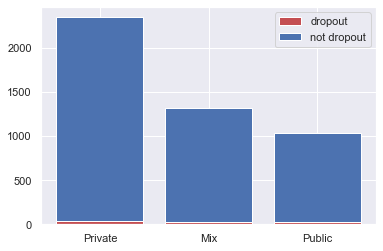

In [11]:
def f(var):
    N = ['Private','Mix', 'Public']
    drop = np.array(A.loc[Y[var]==1,"Grupo_Dependencia_Colegio_F"].value_counts()).flatten()
    not_drop = np.array(A.loc[Y[var]==0,"Grupo_Dependencia_Colegio_F"].value_counts()).flatten()
    plt.bar(N, drop, color = 'r', label='dropout')
    plt.bar(N, not_drop, bottom = drop, color='b', label='not dropout')
    plt.legend()
    plt.show()
    
l = []
for var in Y.columns:
    l.append((var,var))

interact(f, var=l);

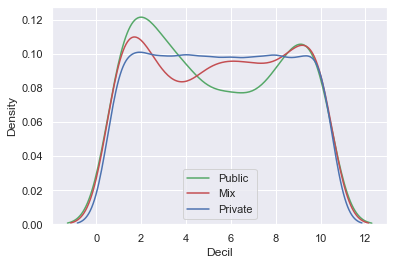

In [12]:
#Save the numerical and nominal variables
numerical = [i for i, e in enumerate(X.dtypes) if e == 'float64']

def f(var):
    fig, ax1 = plt.subplots()

    sns.axes_style("darkgrid")
    sns.kdeplot(X[A['Grupo_Dependencia_Colegio_F']=='Municipal'][var], color='g', label = 'Public')
    sns.kdeplot(X[A['Grupo_Dependencia_Colegio_F']=='Particular Subvencionado'][var], color='r', label = 'Mix')
    sns.kdeplot(X[A['Grupo_Dependencia_Colegio_F']=='Particular Pagado'][var], color='b', label = 'Private')

    
    ax1.legend()
    
    plt.show()

l = []
for var in X.iloc[:,numerical].columns:
    l.append((var,var))
    
interact(f, var=l);

In [13]:
for label in Y.columns:
    res = pd.crosstab(A['Grupo_Dependencia_Colegio_F'],Y[label])
    print('Y='+label)
    for x in list(pd.crosstab(A['Grupo_Dependencia_Colegio_F'],Y[label]).index):
        total_des = res.loc[x,1]
        total_gen = res.loc[x,:].sum()
        print("For High School type={0}, the rate of dropout is: {1:.2%}".format(x,total_des/total_gen))
    print()
    
print('Note: "Municipal" is Public, "Particular Pagado" is private, and "Particupar Subvencionado" is Mix (the HS is financed with public and private funds)')

Y=CausalSem-11
For High School type=Municipal, the rate of dropout is: 3.45%
For High School type=Particular Pagado, the rate of dropout is: 1.15%
For High School type=Particular Subvencionado, the rate of dropout is: 2.34%

Y=CausalSem-12
For High School type=Municipal, the rate of dropout is: 12.94%
For High School type=Particular Pagado, the rate of dropout is: 6.32%
For High School type=Particular Subvencionado, the rate of dropout is: 13.98%

Y=CausalSem-2v
For High School type=Municipal, the rate of dropout is: 3.07%
For High School type=Particular Pagado, the rate of dropout is: 0.98%
For High School type=Particular Subvencionado, the rate of dropout is: 2.87%

Y=CausalSem-21
For High School type=Municipal, the rate of dropout is: 16.11%
For High School type=Particular Pagado, the rate of dropout is: 7.14%
For High School type=Particular Subvencionado, the rate of dropout is: 13.30%

Y=CausalSem-22
For High School type=Municipal, the rate of dropout is: 14.38%
For High School ty

After analysis and for convenience, A regarding to High School type will be dummified into Public and Not Public.

Plotting label rate using public_school transformation.

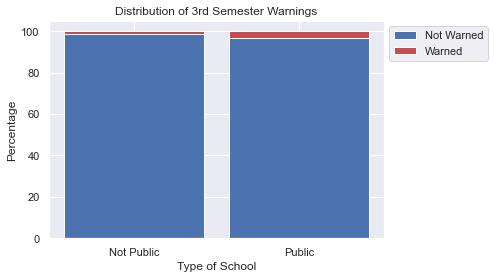

In [14]:
def f(var):
    N = ['Not Public', 'Public']
    totals = [i+j for i,j in zip(A_dummy.loc[Y[var]==0,"public_school"].value_counts(), A_dummy.loc[Y[var]==1,"public_school"].value_counts())]
    blueBars = [i / j * 100 for i,j in zip(A_dummy.loc[Y[var]==0,"public_school"].value_counts(), totals)]
    redBars = [i / j * 100 for i,j in zip(A_dummy.loc[Y[var]==1,"public_school"].value_counts(), totals)]
    
    # plot
    barWidth = 0.85
    # Create green Bars
    plt.bar(N, blueBars, color='b', edgecolor='white', width=barWidth, label = 'Not Warned')
    # Create orange Bars
    plt.bar(N, redBars, bottom=blueBars, color='r', edgecolor='white', width=barWidth, label = 'Warned')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    
    plt.title('Distribution of 3rd Semester Warnings')
    plt.xlabel('Type of School')
    plt.ylabel('Percentage')
    plt.show()
    
l = []
for var in Y.columns:
    l.append((var,var))

interact(f, var=l);


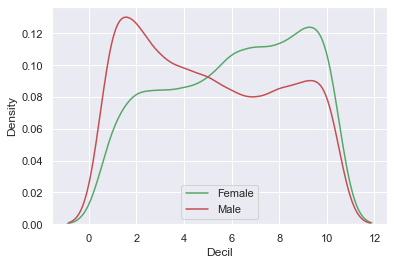

In [16]:
#Save the numerical and nominal variables
numerical = [i for i, e in enumerate(X.dtypes) if e == 'float64']

def f(var, sensitive_attr):
    fig, ax1 = plt.subplots()
    
    if sensitive_attr == 'public_school':
        group1 = 'Public'
        group2 = 'Not Public'
    elif sensitive_attr =='gender':
        group1 = 'Female'
        group2 = 'Male'
    else:
        group1 = 'Female or Public'
        group2 = 'Male and Not Public'

    
    sns.axes_style("darkgrid")
    sns.kdeplot(X[A_dummy[sensitive_attr]==1][var], color='g', label = group1)
    sns.kdeplot(X[A_dummy[sensitive_attr]==0][var], color='r', label = group2)
    
    ax1.set_xlabel(var)
    ax1.legend()
    
    plt.show()

l = []
for var in X.iloc[:,numerical].columns:
    l.append((var,var))
    
s = [('Gender','gender'), ('School Type','public_school'), ('Elite', 'elite')]
    
interact(f, var=l, sensitive_attr=s);